In [1]:
import requests
import pandas as pd
import time
import requests
import os
import pandas as pd
import matplotlib.pyplot as plt

from rdflib import Graph







### Tools and Technologies Used

#### Centraliz federated accessed Setup
- **Data Cleaning & Transformation**: R scripts for each lab (customized mappings and filte
- **Data Format**: after cleaning RDF triples aligned with the Livestock Health Ontology (LHO)rs)
- **Automation Pipeline**: Quarto + GitHub Actions for scheduled processing
- **Data Storage Format**: Flat `.csv` file (10 standardized fields)
- **Visualization**: Tableau dashboards
- **Repository**: [GitHub – Cattle Barometer](https://github.com/decide-project-eu/cattle-use-case-barometer)
- **Tutorial**: [DECIDE Cattle Barometer Guide](https://decide-project-eu.github.io/case-studies-website/tutorials/cattle-barometer.html )

#### Dec fedrated accessentralized Setup (Solid Pods)
- **Data Format**: RDF triples aligned with the Livestock Health Ontology (LHO)
- **Pod Hosting**: [Solid Pod deployment](https://solidserver.bovi-analytics.com)
- **SPARQL Query Engine**: Comunica engine
- **Federated API Deployment**: [Azure Function Endpoint](https://decide-federated-functions.azurewebsites.net/api/FedQuery)
- **D and for access control policiesata Upload Tool**: [PENNY RDF uploader](https://github.com/djsf-kobayashi/penny)
- **Visualization**: Tableau (fed with real-time query results)
- **Ontology**: [Livestock Health Ontology on GitHub](https://github.com/decide-project-eu/LivestockHealthOntology)


# ...............................><...........................
# Experiment 01 – Cattle Barometer data Federation
# ................................><.............................

##### Cattle-data- Vertical Federation
##### Show that federated SPARQL queries over RDF data from multiple cattle labs can power the Cattle Barometer decision-support tool

In [2]:


# List of TTL files from the 5 cattle labs
cattle_files = [
    "https://solidserver.bovi-analytics.com/decide_lab1/Vertical/RDFoutputCattleSampleLab1.ttl",
    "https://solidserver.bovi-analytics.com/decide_lab2/Vertical/RDFoutputCattleSampleLab2.ttl",
    "https://solidserver.bovi-analytics.com/decide_lab3/Vertical/RDFoutputCattleSampleLab3.ttl",
    "https://solidserver.bovi-analytics.com/decide_lab4/Vertical/RDFoutputCattleSampleLab4.ttl",
    "https://solidserver.bovi-analytics.com/decide_lab5/Vertical/RDFoutputCattleSampleLab5.ttl"
]

total_triples = 0

for file in cattle_files:
    g = Graph()
    g.parse(file, format="ttl")
    count = len(g)
    print(f"{file}: {count} triples")
    total_triples += count

print(f"\n Total RDF triples across all 5 cattle labs: {total_triples}")


https://solidserver.bovi-analytics.com/decide_lab1/Vertical/RDFoutputCattleSampleLab1.ttl: 227310 triples
https://solidserver.bovi-analytics.com/decide_lab2/Vertical/RDFoutputCattleSampleLab2.ttl: 148574 triples
https://solidserver.bovi-analytics.com/decide_lab3/Vertical/RDFoutputCattleSampleLab3.ttl: 267168 triples
https://solidserver.bovi-analytics.com/decide_lab4/Vertical/RDFoutputCattleSampleLab4.ttl: 5980 triples
https://solidserver.bovi-analytics.com/decide_lab5/Vertical/RDFoutputCattleSampleLab5.ttl: 91024 triples

 Total RDF triples across all 5 cattle labs: 740056


In [12]:
import time
import requests
import pandas as pd

# Azure Function endpoint
url = "https://decide-federated-functions.azurewebsites.net/api/FedQuery"

# SPARQL query + sources



payload = {
    "sparql": """
    PREFIX LHO: <http://www.purl.org/decide/LiveStockHealthOnto/LHO#>

    SELECT ?Sample ?Pathogen ?Breed ?SampleType ?DiagnosticTest ?Country ?Province ?SampleResult
    WHERE {
        ?Sample a LHO:CattleSample ;
                LHO:hasPathogen ?Pathogen ;
                LHO:hasSampleType ?SampleType ;
                LHO:hasCountry ?Country ;
                LHO:hasProvince ?Province ;
                LHO:hasBreed ?Breed ;
                LHO:hasDiagnosticTest ?DiagnosticTest ;
                LHO:hasResult ?SampleResult .

        FILTER(?Pathogen = LHO:MB)
        FILTER(?SampleType = LHO:Swab)
        FILTER(?SampleResult = LHO:1)
    }
    """,
    "sources": [
        "https://solidserver.bovi-analytics.com/decide_lab1/Vertical/RDFoutputCattleSampleLab1.ttl",
        "https://solidserver.bovi-analytics.com/decide_lab2/Vertical/RDFoutputCattleSampleLab2.ttl",
        "https://solidserver.bovi-analytics.com/decide_lab3/Vertical/RDFoutputCattleSampleLab3.ttl",
        "https://solidserver.bovi-analytics.com/decide_lab4/Vertical/RDFoutputCattleSampleLab4.ttl",
        "https://solidserver.bovi-analytics.com/decide_lab5/Vertical/RDFoutputCattleSampleLab5.ttl"
    ]
}


# Start timing
start_time = time.time()     #For Time


headers = {
    "Authorization": "Bearer <ACCESS_TOKEN_FROM_SOLID_IDP>",  # Replace with access token
    "Content-Type": "application/json"
}

# Send POST request with authentication header
response = requests.post(url, json=payload, headers=headers)



# End timing
end_time = time.time()
response_time = end_time - start_time
print(f"Query Response Time: {response_time:.2f} seconds")

# Check for success
if response.status_code == 200:
    try:
        raw_data = response.json()

        columns = ["Sample", "Pathogen", "Breed", "SampleType", "DiagnosticTest", "Country", "Province", "SampleResult"]

        cleaned_rows = []

        def extract_label(uri):
            if uri:
                return uri.split("#")[-1].replace("-", " ")
            return None

        for item in raw_data:
            row = {col: extract_label(item.get(col, None)) for col in columns}
            cleaned_rows.append(row)

        # Create DataFrame
        df = pd.DataFrame(cleaned_rows, columns=columns)

        # Save to CSV
        Barometer = "fedquery_cleaned_results.csv"
        df.to_csv(Barometer, index=False)

        print(f"Query successful! Results saved to '{Barometer}'")
        print(f"Number of RDF triples (rows) processed: {total_triples}")     #####Number of RDF triples (rows) processed

        display(df.head (100))

    except Exception as e:
        print("Failed to process response JSON:", str(e))

else:
    print(f"Request failed. Status code: {response.status_code}")
    print(response.text)


Query Response Time: 195.74 seconds
Query successful! Results saved to 'fedquery_cleaned_results.csv'
Number of RDF triples (rows) processed: 740056


,Sample,Pathogen,Breed,SampleType,DiagnosticTest,Country,Province,SampleResult
0,Lab3CattleSample_24479,MB,Beef,Swab,PCR,Belgium,Luxemburg,1
1,Lab1CattleSample_10014,MB,Dairy,Swab,PCR,Belgium,Limburg,1
2,Lab3CattleSample_24486,MB,Beef,Swab,PCR,Belgium,Luxemburg,1
3,Lab3CattleSample_24493,MB,Beef,Swab,PCR,Belgium,Luxemburg,1
4,Lab2CattleSample_51880,MB,Dairy,Swab,Culture,TheNetherlands,Drenthe,1
...,...,...,...,...,...,...,...,...
95,Lab1CattleSample_14336,MB,Dairy,Swab,PCR,Belgium,Antwerp,1
96,Lab3CattleSample_29617,MB,Beef,Swab,PCR,Belgium,Luik,1
97,Lab3CattleSample_29652,MB,Beef,Swab,Culture,Belgium,Luxemburg,1
98,Lab3CattleSample_29666,MB,Beef,Swab,PCR,Belgium,Luxemburg,1


# Experiment 02 – 

# ...............................><...........................
# Vertical Federation (Species-Specific Pods)
# ................................><.............................

#### Simple Query with Batching


To evaluate baseline performance, we ran simple federated SPARQL queries over homogeneous species-specific Solid Pods using a batching strategy. Because each batch (e.g., cattle, pig, or poultry) contains data from a single species and shares a consistent schema and ontology structure across its pods. For example, cattle data was queried from Pods 1–5, pig data from Pods 6–11, and poultry data from Pod 12. 

Each group was queried independently with increasing LIMIT values (5000, 10000, 15000 triples/rows of data) to test scalability.

Although the queries targeted homogeneous data (i.e., data from the same species and schema), the number of RDF triples and dataset sizes varied across the pods. This uneven distribution reflects real-world data heterogeneity within species-level labs.

The query structure was intentionally lightweight—retrieving only key attributes such as Sample, Pathogen, SampleType,and SampleResults to isolate the impact of scalability rather than query complexity.

In [6]:
from rdflib import Graph

# List of TTL files from the 5 cattle labs
Total_files = [
         "https://solidserver.bovi-analytics.com/decide_lab1/Vertical/RDFoutputCattleSampleLab1.ttl",
         "https://solidserver.bovi-analytics.com/decide_lab2/Vertical/RDFoutputCattleSampleLab2.ttl",
         "https://solidserver.bovi-analytics.com/decide_lab3/Vertical/RDFoutputCattleSampleLab3.ttl",
         "https://solidserver.bovi-analytics.com/decide_lab4/Vertical/RDFoutputCattleSampleLab4.ttl",
         "https://solidserver.bovi-analytics.com/decide_lab5/Vertical/RDFoutputCattleSampleLab5.ttl",
        "https://solidserver.bovi-analytics.com/decide_lab6/Vertical/PigLab1.ttl",
        "https://solidserver.bovi-analytics.com/decide_lab7/Vertical/PigLab2.ttl",
        "https://solidserver.bovi-analytics.com/decide_lab8/Vertical/PigLab3.ttl",
        "https://solidserver.bovi-analytics.com/decide_lab9/Vertical/PigLab4.ttl",
        "https://solidserver.bovi-analytics.com/decide_lab10/Vertical/PigLab5.ttl",
        "https://solidserver.bovi-analytics.com/decide_lab11/Vertical/PigLab6.ttl",
        "https://solidserver.bovi-analytics.com/decide_lab12/Vertical/Poultrylab1.ttl",
]

total_triples = 0

for file in Total_files:
    g = Graph()
    g.parse(file, format="ttl")
    count = len(g)
    print(f"{file}: {count} triples")
    total_triples += count

print(f"\n Total RDF triples across all 12  labs: {total_triples}")


https://solidserver.bovi-analytics.com/decide_lab1/Vertical/RDFoutputCattleSampleLab1.ttl: 227310 triples
https://solidserver.bovi-analytics.com/decide_lab2/Vertical/RDFoutputCattleSampleLab2.ttl: 148574 triples
https://solidserver.bovi-analytics.com/decide_lab3/Vertical/RDFoutputCattleSampleLab3.ttl: 267168 triples
https://solidserver.bovi-analytics.com/decide_lab4/Vertical/RDFoutputCattleSampleLab4.ttl: 5980 triples
https://solidserver.bovi-analytics.com/decide_lab5/Vertical/RDFoutputCattleSampleLab5.ttl: 91024 triples
https://solidserver.bovi-analytics.com/decide_lab6/Vertical/PigLab1.ttl: 11359 triples
https://solidserver.bovi-analytics.com/decide_lab7/Vertical/PigLab2.ttl: 5329 triples
https://solidserver.bovi-analytics.com/decide_lab8/Vertical/PigLab3.ttl: 5891 triples
https://solidserver.bovi-analytics.com/decide_lab9/Vertical/PigLab4.ttl: 5646 triples
https://solidserver.bovi-analytics.com/decide_lab10/Vertical/PigLab5.ttl: 5629 triples
https://solidserver.bovi-analytics.com/de

In [9]:
import time
import requests
import pandas as pd

# Configuration
endpoint = "https://decide-federated-functions.azurewebsites.net/api/FedQuery"
limits = [5000, 10000, 15000]
columns = ["Sample", "Pathogen", "SampleType", "Species"]

# Pod groups
cattle_pods = [
    f"https://solidserver.bovi-analytics.com/decide_lab{i}/Vertical/RDFoutputCattleSampleLab{i}.ttl"
    for i in range(1, 6)
]
pig_pods = [
    f"https://solidserver.bovi-analytics.com/decide_lab{i}/Vertical/PigLab{i-5}.ttl"
    for i in range(6, 12)
]
poultry_pod = ["https://solidserver.bovi-analytics.com/decide_lab12/Vertical/Poultrylab1.ttl"]

def extract_label(uri):
    if uri:
        return uri.split("#")[-1].replace("-", " ")
    return None

# SPARQL Query Template
def build_query(limit):
    return f"""
        PREFIX LHO: <http://www.purl.org/decide/LiveStockHealthOnto/LHO#>
        SELECT ?Sample ?Species ?Pathogen ?SampleType ?Breed ?DiagnosticTest ?Country ?SampleResult

        WHERE {{
          {{
            ?Sample a LHO:CattleSample ;
                    LHO:hasPathogen ?Pathogen ;
                    LHO:hasSampleType ?SampleType ;
                    
                    
            BIND("Cattle" AS ?Species)
          }}
          UNION
          {{
            ?Sample a LHO:PigSample ;
                    LHO:hasPathogen ?Pathogen ;
                    LHO:hasSampleType ?SampleType .
            BIND("Pig" AS ?Species)
          }}
          UNION
          {{
            ?Sample a LHO:PoultrySample ;
                    LHO:hasPathogen ?Pathogen ;
                    LHO:hasSampleType ?SampleType .
            BIND("Poultry" AS ?Species)
          }}
        }}
        LIMIT {limit}
    """

# Run batched queries and store results
def run_batch_query(label, sources, limit):
    sparql_query = build_query(limit)
    payload = {"sparql": sparql_query, "sources": sources}
    start_time = time.time()

    try:
        response = requests.post(endpoint, json=payload)
        response_time = round(time.time() - start_time, 2)
        if response.status_code == 200:
            raw_data = response.json()
            cleaned_rows = [
                {col: extract_label(item.get(col)) for col in columns}
                for item in raw_data
            ]
            df = pd.DataFrame(cleaned_rows, columns=columns)
            filename = f"{label}_result_L{limit}.csv"
            df.to_csv(filename, index=False)
            return {"Label": label, "Limit": limit, "Rows": len(df), "Time": response_time, "Status": "Success"}
        else:
            return {"Label": label, "Limit": limit, "Rows": 0, "Time": None, "Status": f"HTTP {response.status_code}"}
    except Exception as e:
        return {"Label": label, "Limit": limit, "Rows": 0, "Time": None, "Status": str(e)}

# Run all batches
results = []
for limit in limits:
    results.append(run_batch_query("Cattle", cattle_pods, limit))
    results.append(run_batch_query("Pig", pig_pods, limit))
    results.append(run_batch_query("Poultry", poultry_pod, limit))

results_df = pd.DataFrame(results)
print(results_df)
results_df.to_csv("federated_batch_results.csv", index=False)




     Label  Limit   Rows    Time   Status
0   Cattle   5000   5000   40.58  Success
1      Pig   5000   4248   33.52  Success
2  Poultry   5000   1889    2.74  Success
3   Cattle  10000  10000   73.93  Success
4      Pig  10000   4248   32.14  Success
5  Poultry  10000   1889    4.14  Success
6   Cattle  15000  15000  127.30  Success
7      Pig  15000   4248   36.25  Success
8  Poultry  15000   1889    5.15  Success


#### Complex Query Attempt (Vertical)

 In this experement we use a same setup homogeneous species-specific Solid Pods using a batching strategy. But this time we tested more complex SPARQL queries involving multi-variable filters and UNION operations across species.
 
While these worked at smaller scales, they began to fail with HTTP 500 errors as the number of pods or LIMIT increased. 

These failures were not due to flaws in the federation model itself, but rather stemmed from Azure Function timeouts (≈230s), and query complexity. Potential solutions include breaking queries into smaller batches, paginating results, or increasing Azure timeout settings.

In [10]:

# Configuration
endpoint = "https://decide-federated-functions.azurewebsites.net/api/FedQuery"
limits = [500, 1000, 15000]
columns = ["Sample", "Pathogen", "Breed", "SampleType", "DiagnosticTest",
           "ProductionStages", "Country", "Province", "SampleResult", "Species"]

# Pod groups
cattle_pods = [
    f"https://solidserver.bovi-analytics.com/decide_lab{i}/Vertical/RDFoutputCattleSampleLab{i}.ttl"
    for i in range(1, 6)
]
pig_pods = [
    f"https://solidserver.bovi-analytics.com/decide_lab{i}/Vertical/PigLab{i-5}.ttl"
    for i in range(6, 12)
]
poultry_pod = ["https://solidserver.bovi-analytics.com/decide_lab12/Vertical/Poultrylab1.ttl"]

def extract_label(uri):
    if uri:
        return uri.split("#")[-1].replace("-", " ")
    return None

# SPARQL Query Template (cleaned)
def build_query(limit):
    return f"""
    PREFIX LHO: <http://www.purl.org/decide/LiveStockHealthOnto/LHO#>
    SELECT ?Sample ?Species ?Pathogen ?Breed ?SampleType ?DiagnosticTest ?ProductionStages ?Country ?Province ?SampleResult
    WHERE {{
      {{
        ?Sample a LHO:CattleSample ;
                LHO:hasPathogen ?Pathogen ;
                LHO:hasCountry ?Country ;
                LHO:hasProvince ?Province ;
                LHO:hasResult ?SampleResult ;
                LHO:hasBreed ?Breed ;
                LHO:hasSampleType ?SampleType ;
                LHO:hasDiagnosticTest ?DiagnosticTest .
        FILTER(?Pathogen = LHO:MB)
        FILTER(?SampleType = LHO:Swab)
        FILTER(?SampleResult = LHO:1)
        BIND("NA" AS ?ProductionStages)
        BIND("Cattle" AS ?Species)
      }}
      UNION
      {{
        ?Sample a LHO:PigSample ;
                LHO:hasPathogen ?Pathogen ;
                LHO:hasCountry ?Country ;
                LHO:hasProvince ?Province ;
                LHO:hasResult ?SampleResult ;
                LHO:hasBreed ?Breed ;
                LHO:hasSampleType ?SampleType ;
                LHO:hasDiagnosticTest ?DiagnosticTest ;
                LHO:hasProductionStages ?PigProductionStage .
        FILTER(?Pathogen = LHO:Mycoplasma_hyopneumoniae)
        FILTER(?SampleType = LHO:Tissue)
        FILTER(?PigProductionStage = LHO:Finishing)
        FILTER(?SampleResult = LHO:1)
        BIND(?PigProductionStage AS ?ProductionStages)
        BIND("Pig" AS ?Species)
      }}
      UNION
      {{
        ?Sample a LHO:PoultrySample ;
                LHO:hasPathogen ?Pathogen ;
                LHO:hasBreed ?Breed ;
                LHO:hasSampleType ?SampleType ;
                LHO:hasProductionStages ?PoultryProductionStage ;
                LHO:hasCountry ?Country ;
                LHO:hasProvince ?Province ;
                LHO:hasResult ?SampleResult .
        FILTER(?Pathogen = LHO:QX)
        FILTER(?SampleType = LHO:SS)
        FILTER(?PoultryProductionStage = LHO:Broiler)
        FILTER(?SampleResult = LHO:1)
        BIND(?PoultryProductionStage AS ?ProductionStages)
        BIND("Poultry" AS ?Species)
        BIND("NA" AS ?DiagnosticTest)
      }}
    }}
    LIMIT {limit}
    """

# Run batched queries and store results
def run_batch_query(label, sources, limit, species):
    sparql_query = build_query(limit)
    payload = {"sparql": sparql_query, "sources": sources}
    start_time = time.time()

    try:
        response = requests.post(endpoint, json=payload)
        response_time = round(time.time() - start_time, 2)
        if response.status_code == 200:
            raw_data = response.json()
            cleaned_rows = [
                {col: extract_label(item.get(col)) for col in columns}
                for item in raw_data
            ]
            df = pd.DataFrame(cleaned_rows, columns=columns)
            filename = f"{label}_result_L{limit}.csv"
            df.to_csv(filename, index=False)
            return {"Label": label, "Limit": limit, "Rows": len(df), "Time": response_time, "Status": "Success"}
        else:
            return {"Label": label, "Limit": limit, "Rows": 0, "Time": None, "Status": f"HTTP {response.status_code}"}
    except Exception as e:
        return {"Label": label, "Limit": limit, "Rows": 0, "Time": None, "Status": str(e)}

# Run all batches
results = []
for limit in limits:
    results.append(run_batch_query("Cattle", cattle_pods, limit, "Cattle"))
    results.append(run_batch_query("Pig", pig_pods, limit, "Pig"))
    results.append(run_batch_query("Poultry", poultry_pod, limit, "Poultry"))

# Display and save results
results_df = pd.DataFrame(results)
print(results_df)
results_df.to_csv("federated_batch_results.csv", index=False)


     Label  Limit  Rows    Time    Status
0   Cattle    500   500  230.30   Success
1      Pig    500    59    4.36   Success
2  Poultry    500   500    2.25   Success
3   Cattle   1000     0     NaN  HTTP 500
4      Pig   1000    59    8.04   Success
5  Poultry   1000   750   54.33   Success


### Queries run:

✅ Simple queries with LIMITs of 5,000 / 10,000 / 15,000 (3 queries per species group)

✅ Complex queries with LIMITs of 500 / 1,000 (2 queries per species group)

### Observations:

Query times scaled linearly with LIMITs.

Some failures (e.g., cattle complex query at LIMIT 1000 gave HTTP 500), but others completed successfully, showing partial resilience.

# ...............................><...........................
#  Horizontal Federation (Species-Mixed Pods)
# ................................><.............................

### Simple Query
In this experiment, we evaluated horizontal federation using 6 Solid Pods, each containing an equal mix of cattle, pig, and poultry data. The goal was to simulate a real-world scenario where data from multiple species co-exists in the same pod.

Simple federated SPARQL queries executed in batch mode performed reliably even with large LIMIT values (e.g., 5000, 10000, 15000 tri[les or rows of data).

However, when we attempted more complex multi-species UNION queries across all 6 mixed pods—especially with larger LIMITs—the system began to fail with HTTP 500 errors. These issues were caused by execution timeouts in Azure Functions, compounded by the increased computational cost of federated link traversal and UNION logic.

It's important to note that these failures are not due to flaws in the federation design, but rather operational constraints. Solutions like result pagination, smaller batch sizes, or extending Azure timeouts can help mitigate this.

# Simple Horizontal Batch Query

In [2]:

# Configuration
endpoint = "https://decide-federated-functions.azurewebsites.net/api/FedQuery"
limits = [5000, 10000, 15000]
columns = ["Sample", "Pathogen", "SampleType", "Species"]

# Horizontal Solid Pods (1 to 6) Species-Mixed Pods
horizontal_pods = [
    f"https://solidserver.bovi-analytics.com/decide_lab{i+1}/Horizontal/HorizontalLab{i+1}.ttl"
    for i in range(6)
]

def extract_label(uri):
    if uri:
        return uri.split("#")[-1].replace("-", " ")
    return None

# SPARQL Query Template
def build_query(limit):
    return f"""
        PREFIX LHO: <http://www.purl.org/decide/LiveStockHealthOnto/LHO#>
        SELECT ?Sample ?Species ?Pathogen ?SampleType
        WHERE {{
          {{
            ?Sample a LHO:CattleSample ;
                    LHO:hasPathogen ?Pathogen ;
                    LHO:hasSampleType ?SampleType .
            BIND("Cattle" AS ?Species)
          }}
          UNION
          {{
            ?Sample a LHO:PigSample ;
                    LHO:hasPathogen ?Pathogen ;
                    LHO:hasSampleType ?SampleType .
            BIND("Pig" AS ?Species)
          }}
          UNION
          {{
            ?Sample a LHO:PoultrySample ;
                    LHO:hasPathogen ?Pathogen ;
                    LHO:hasSampleType ?SampleType .
            BIND("Poultry" AS ?Species)
          }}
        }}
        LIMIT {limit}
    """

# Run batched queries and store results
def run_batch_query(label, sources, limit):
    sparql_query = build_query(limit)
    payload = {"sparql": sparql_query, "sources": sources}
    start_time = time.time()

    try:
        response = requests.post(endpoint, json=payload)
        response_time = round(time.time() - start_time, 2)
        if response.status_code == 200:
            raw_data = response.json()
            cleaned_rows = [
                {col: extract_label(item.get(col)) for col in columns}
                for item in raw_data
            ]
            df = pd.DataFrame(cleaned_rows, columns=columns)
            filename = f"{label}_horizontal_result_L{limit}.csv"
            df.to_csv(filename, index=False)
            return {"Label": label, "Limit": limit, "Rows": len(df), "Time": response_time, "Status": "Success"}
        else:
            return {"Label": label, "Limit": limit, "Rows": 0, "Time": None, "Status": f"HTTP {response.status_code}"}
    except Exception as e:
        return {"Label": label, "Limit": limit, "Rows": 0, "Time": None, "Status": str(e)}

# Run all batches with 6 horizontal pods
results = []
for limit in limits:
    results.append(run_batch_query("Horizontal", horizontal_pods, limit))

# Save and print results
results_df = pd.DataFrame(results)
print(results_df)
results_df.to_csv("output/horizontal_batch_results.csv", index=False)


        Label  Limit   Rows    Time    Status
0  Horizontal   5000   5000  113.71   Success
1  Horizontal  10000  10000  172.70   Success
2  Horizontal  15000      0     NaN  HTTP 500


In [3]:


# Configuration
endpoint = "https://decide-federated-functions.azurewebsites.net/api/FedQuery"
limits = [500, 1000]
columns = ["Sample", "Pathogen", "Breed", "SampleType", "DiagnosticTest",
           "ProductionStages", "Country", "Province", "SampleResult", "Species"]

# Horizontal pod group (all species in each pod)
horizontal_pods = [
    f"https://solidserver.bovi-analytics.com/decide_lab{i+1}/Horizontal/HorizontalLab{i+1}.ttl"
    for i in range(6)
]

def extract_label(uri):
    if uri:
        return uri.split("#")[-1].replace("-", " ")
    return None

# SPARQL Query Template (Complex Multi-Species)
def build_query(limit):
    return f"""
    PREFIX LHO: <http://www.purl.org/decide/LiveStockHealthOnto/LHO#>
    SELECT ?Sample ?Species ?Pathogen ?Breed ?SampleType ?DiagnosticTest ?ProductionStages ?Country ?Province ?SampleResult
    WHERE {{
      {{
        ?Sample a LHO:CattleSample ;
                LHO:hasPathogen ?Pathogen ;
                LHO:hasCountry ?Country ;
                LHO:hasProvince ?Province ;
                LHO:hasResult ?SampleResult ;
                LHO:hasBreed ?Breed ;
                LHO:hasSampleType ?SampleType ;
                LHO:hasDiagnosticTest ?DiagnosticTest .
        FILTER(?Pathogen = LHO:MB)
        FILTER(?SampleType = LHO:Swab)
        FILTER(?SampleResult = LHO:1)
        BIND("NA" AS ?ProductionStages)
        BIND("Cattle" AS ?Species)
      }}
      UNION
      {{
        ?Sample a LHO:PigSample ;
                LHO:hasPathogen ?Pathogen ;
                LHO:hasCountry ?Country ;
                LHO:hasProvince ?Province ;
                LHO:hasResult ?SampleResult ;
                LHO:hasBreed ?Breed ;
                LHO:hasSampleType ?SampleType ;
                LHO:hasDiagnosticTest ?DiagnosticTest ;
                LHO:hasProductionStages ?PigProductionStage .
        FILTER(?Pathogen = LHO:Mycoplasma_hyopneumoniae)
        FILTER(?SampleType = LHO:Tissue)
        FILTER(?PigProductionStage = LHO:Finishing)
        FILTER(?SampleResult = LHO:1)
        BIND(?PigProductionStage AS ?ProductionStages)
        BIND("Pig" AS ?Species)
      }}
      UNION
      {{
        ?Sample a LHO:PoultrySample ;
                LHO:hasPathogen ?Pathogen ;
                LHO:hasBreed ?Breed ;
                LHO:hasSampleType ?SampleType ;
                LHO:hasProductionStages ?PoultryProductionStage ;
                LHO:hasCountry ?Country ;
                LHO:hasProvince ?Province ;
                LHO:hasResult ?SampleResult .
        FILTER(?Pathogen = LHO:QX)
        FILTER(?SampleType = LHO:SS)
        FILTER(?PoultryProductionStage = LHO:Broiler)
        FILTER(?SampleResult = LHO:1)
        BIND(?PoultryProductionStage AS ?ProductionStages)
        BIND("Poultry" AS ?Species)
        BIND("NA" AS ?DiagnosticTest)
      }}
    }}
    LIMIT {limit}
    """

# Run single batch query for horizontal federation
def run_batch_query(label, sources, limit):
    sparql_query = build_query(limit)
    payload = {"sparql": sparql_query, "sources": sources}
    start_time = time.time()

    try:
        response = requests.post(endpoint, json=payload)
        response_time = round(time.time() - start_time, 2)
        if response.status_code == 200:
            raw_data = response.json()
            cleaned_rows = [
                {col: extract_label(item.get(col)) for col in columns}
                for item in raw_data
            ]
            df = pd.DataFrame(cleaned_rows, columns=columns)
            filename = f"{label}_horizontal_complex_L{limit}.csv"
            df.to_csv(filename, index=False)
            return {"Label": label, "Limit": limit, "Rows": len(df), "Time": response_time, "Status": "Success"}
        else:
            return {"Label": label, "Limit": limit, "Rows": 0, "Time": None, "Status": f"HTTP {response.status_code}"}
    except Exception as e:
        return {"Label": label, "Limit": limit, "Rows": 0, "Time": None, "Status": str(e)}

# Execute for all limits
results = []
for limit in limits:
    results.append(run_batch_query("Horizontal", horizontal_pods, limit))

# Output results
results_df = pd.DataFrame(results)
print(results_df)
results_df.to_csv("horizontal_complex_batch_results.csv", index=False)


        Label  Limit  Rows    Time    Status
0  Horizontal    500   500  205.27   Success
1  Horizontal   1000     0     NaN  HTTP 500


# ...............................><...........................
# Results and Evaluation
# ................................><.............................

### Cetralized vs decentalized (Cattle Barometer data)

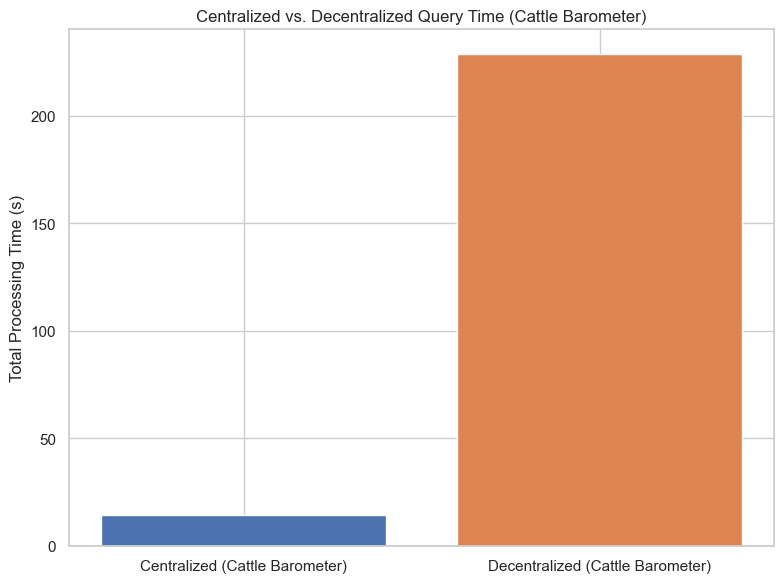

In [21]:
import matplotlib.pyplot as plt

# Data for Cattle Barometer comparison
labels = ['Centralized (Cattle Barometer)', 'Decentralized (Cattle Barometer)']
times = [14.21, 228.79]

# Define colors
colors = ['#4c72b0', '#dd8452']

# Create bar plot
plt.figure(figsize=(8, 6))
plt.bar(labels, times, color=colors)
plt.ylabel('Total Processing Time (s)')
plt.title('Centralized vs. Decentralized Query Time (Cattle Barometer)')
plt.tight_layout()
plt.savefig("Graphs/CattleBarometer_Centralized_vs_Decentralized.png")
plt.show()


#### Query Performance: Simple Batch queries

##### Simple Vertical Federation (Species specific)

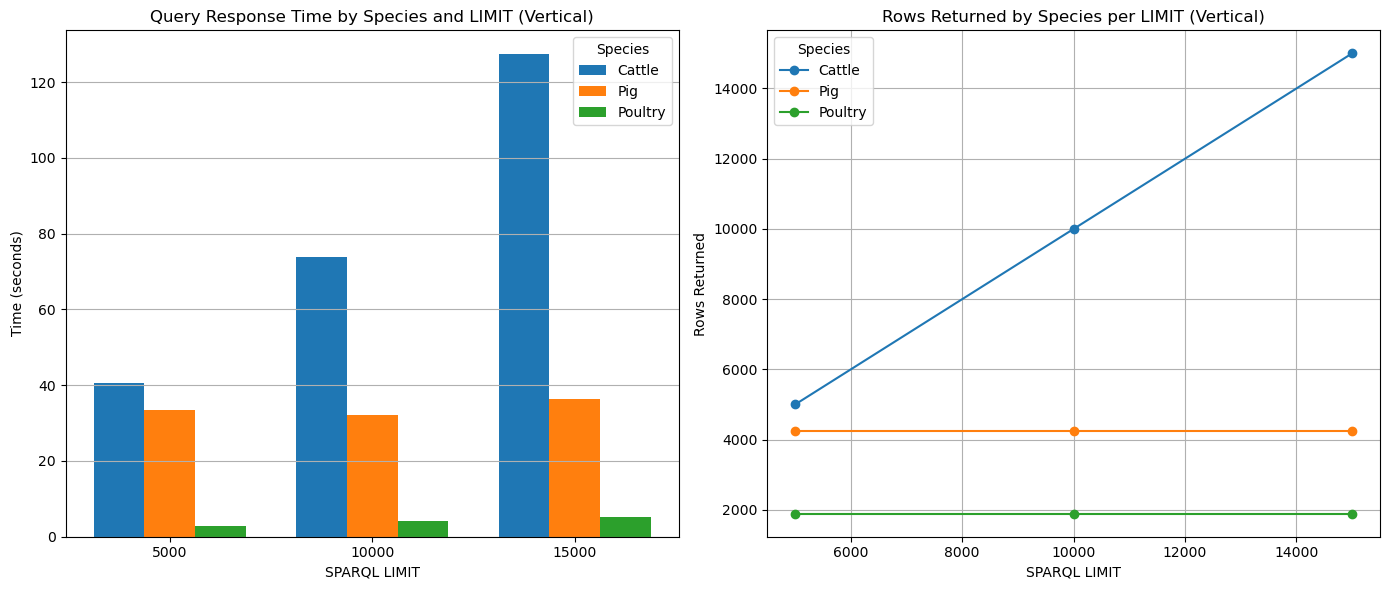

In [11]:
# ....................................><........................................
#Insight: Query Response Time by Species and LIMIT (Vertical Federation simple query) 
# This graph  validates the effect of dataset size on federated query performance, also justifies the use of batching or species-wise federation in large-scale deployments
# This bar chart clearly demonstrates how query response time scales with  the amount of data available per species across vertically federated Solid Pods.

# Cattle:
# Query times increase sharply with higher LIMITs because the cattle pods (Lab1–Lab5) 
# contain a significantly larger number of RDF triples. The linearly increasing time 
# reflects the growing overhead of retrieving and processing more RDF data.


#
# Pig:
# Performance remains relatively steady, with minor variations. This is due to the 
# limited number of pig triples (~5K–14K per pod), meaning the LIMIT is quickly 
# saturated and additional triples aren't available to fetch, keeping query time flat.
#
# Poultry:
# The query time remains low and stable regardless of LIMIT since the poultry pod 
# contains a much smaller data volume (~19K triples total). The LIMIT exceeds what 
# exists in the pod, so the actual query cost is bounded by the pod’s small size.
#2nd Plot shows #Notably, Cattle returns the full number of rows for each limit—5000, 10000, and 15000—indicating that the cattle pods contain a large volume of RDF triples matching the query conditions (e.g., specific Pathogen and SampleType). 
#In contrast, Pig consistently returns 4248 rows, and Poultry returns 1889 rows, regardless of the specified limit. This plateau effect implies that the total number of matching triples across the pig and poultry pods is lower than the requested LIMIT, and once all relevant data is retrieved, increasing the limit has no further impact. 
#..........................................><......................................


# Sample performance results from vertical experiment
data = {
    "Label": ["Cattle", "Pig", "Poultry"] * 3,
    "Limit": [5000, 5000, 5000, 10000, 10000, 10000, 15000, 15000, 15000],
    "Rows": [5000, 4248, 1889, 10000, 4248, 1889, 15000, 4248, 1889],
    "Time": [40.58, 33.52, 2.74, 73.93, 32.14, 4.14, 127.30, 36.25, 5.15]
}

df = pd.DataFrame(data)

# Prepare grouped bar chart for Query Time
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Bar chart: Query Time by Species and LIMIT
labels = df['Label'].unique()
limits = sorted(df['Limit'].unique())
bar_width = 0.25
positions = range(len(limits))

for idx, label in enumerate(labels):
    subset = df[df['Label'] == label]
    axs[0].bar([p + bar_width * idx for p in positions], subset["Time"], width=bar_width, label=label)

axs[0].set_title("Query Response Time by Species and LIMIT (Vertical)")
axs[0].set_xlabel("SPARQL LIMIT")
axs[0].set_ylabel("Time (seconds)")
axs[0].set_xticks([p + bar_width for p in positions])
axs[0].set_xticklabels(limits)
axs[0].legend(title="Species")
axs[0].grid(axis='y')

# Line plot: Rows Returned by Species and LIMIT
for label in labels:
    subset = df[df["Label"] == label]
    axs[1].plot(subset["Limit"], subset["Rows"], marker='o', label=label)

axs[1].set_title("Rows Returned by Species per LIMIT (Vertical)")
axs[1].set_xlabel("SPARQL LIMIT")
axs[1].set_ylabel("Rows Returned")
axs[1].legend(title="Species")
axs[1].grid(True)

plt.tight_layout()
plt.savefig("Graphs/Vertical_QueryTime_And_RowsReturned.png")
plt.show()


##### Horizontal Fedration (Mixed Species)

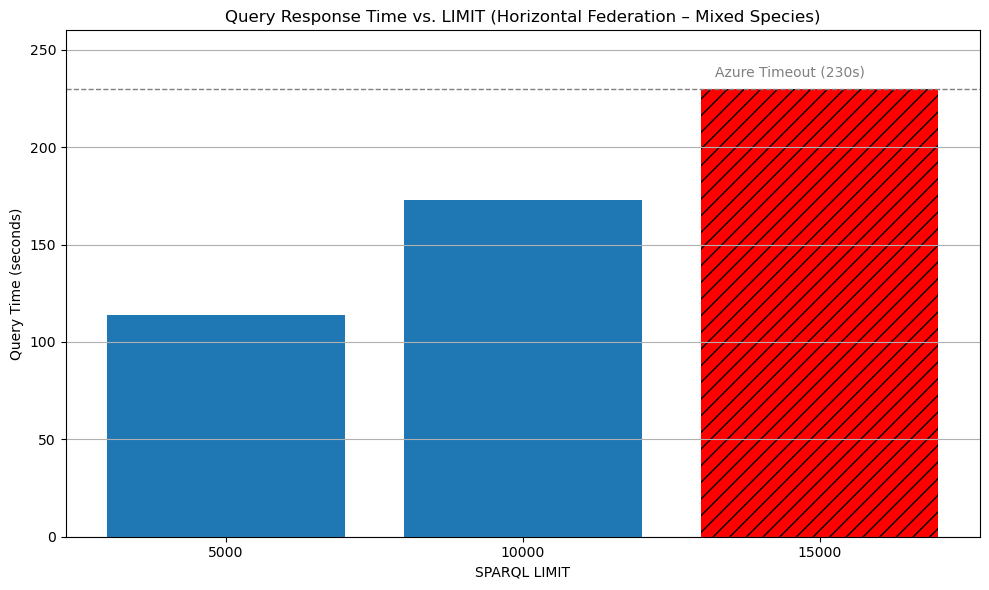

In [14]:
#......................................><.............................................
#horizontal federation over mixed-species Solid Pods,
#In this setup each pod (Pod 1 to 6)contains approximately 170,000 RDF triples, with data evenly distributed across the heterogeneous species structure. 
#At LIMIT 5000 and LIMIT 10000, query execution completes successfully, with response times rising steadily, indicating that the query engine needs to traverse and process more RDF triples as the result set expands.
#However, when the query is executed at LIMIT 15000, the system fails with an HTTP 500 error. 
#This failure is visualized as a red bar with a hatch pattern, and corresponds to exceeding the Azure Function timeout threshold of 230 seconds, shown by the horizontal dashed line.
#The failure at 15000 shows how querying large federated RDF graphs, even with simple filters, can quickly become computationally intensive,
#especially when the number of results requested grows beyond the capacity of the execution time window, 230 seconds on Azure.
#......................................><..............................................

# Horizontal Federation Results (Mixed Species)
horizontal_data = {
    "LIMIT": [5000, 10000, 15000],
    "Time": [113.71, 172.70, 230],  # Use 230 to represent timeout visually
    "Status": ["Success", "Success", "HTTP 500"]
}

df = pd.DataFrame(horizontal_data)

# Colors based on status
colors = ['#1f77b4' if status == "Success" else 'red' for status in df["Status"]]
hatch = [None if status == "Success" else '//' for status in df["Status"]]

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(df["LIMIT"].astype(str), df["Time"], color=colors)

# Apply hatching for HTTP 500
for bar, pattern in zip(bars, hatch):
    if pattern:
        bar.set_hatch(pattern)

# Timeout line
timeout_threshold = 230
ax.axhline(timeout_threshold, color='gray', linestyle='--', linewidth=1)
ax.text(1.9, timeout_threshold + 5, 'Azure Timeout (230s)', ha='center', va='bottom', fontsize=10, color='gray')

# Formatting
ax.set_title("Query Response Time vs. LIMIT (Horizontal Federation – Mixed Species)")
ax.set_xlabel("SPARQL LIMIT")
ax.set_ylabel("Query Time (seconds)")
ax.set_ylim(0, 260)
ax.grid(axis='y')

# Save
plt.tight_layout()
plt.savefig("Graphs/Query Response Time vs. LIMIT (Horizontal Federation – Mixed Species).png")
plt.show()


##### Combined Plot: Vertical vs Horizontal Query Time Comparison 

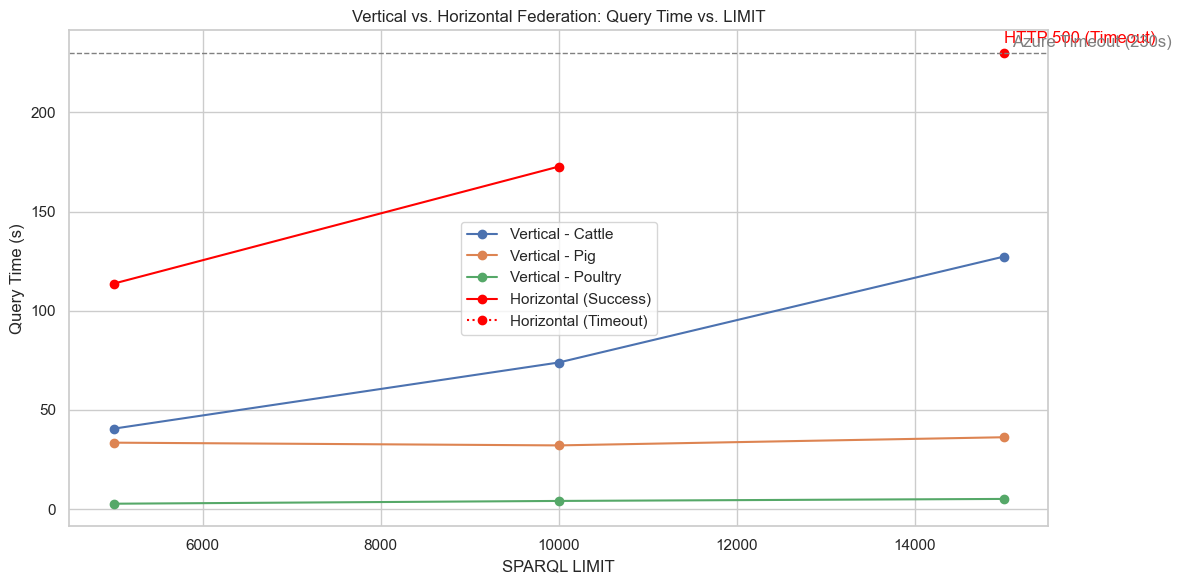

In [19]:
import matplotlib.pyplot as plt
import pandas as pd

# Sample performance data (merged vertical and horizontal)
data = {
    "Label": ["Cattle", "Pig", "Poultry", "Cattle", "Pig", "Poultry", "Cattle", "Pig", "Poultry",
              "Horizontal", "Horizontal", "Horizontal"],
    "LIMIT": [5000, 5000, 5000, 10000, 10000, 10000, 15000, 15000, 15000, 5000, 10000, 15000],
    "Time": [40.58, 33.52, 2.74, 73.93, 32.14, 4.14, 127.3, 36.25, 5.15, 113.71, 172.7, 230],  # Assume timeout at 15000
    "Status": ["Success"] * 11 + ["HTTP 500"]
}

df = pd.DataFrame(data)

# Plot setup
plt.figure(figsize=(12, 6))

# Plot vertical species lines
species = ["Cattle", "Pig", "Poultry"]
for sp in species:
    sp_data = df[df["Label"] == sp]
    plt.plot(sp_data["LIMIT"], sp_data["Time"], marker='o', label=f"Vertical - {sp}")

# Plot horizontal with break for timeout
horizontal_data = df[df["Label"] == "Horizontal"]
horizontal_success = horizontal_data[horizontal_data["Status"] == "Success"]
horizontal_fail = horizontal_data[horizontal_data["Status"] == "HTTP 500"]

# Solid line for successful parts
plt.plot(horizontal_success["LIMIT"], horizontal_success["Time"], marker='o', color='red', label="Horizontal (Success)")

# Dotted line for timeout
if not horizontal_fail.empty:
    plt.plot(horizontal_fail["LIMIT"], horizontal_fail["Time"], marker='o', linestyle=':', color='red', label="Horizontal (Timeout)")
    plt.text(horizontal_fail["LIMIT"].values[0], horizontal_fail["Time"].values[0] + 5,
             'HTTP 500 (Timeout)', color='red')

# Timeout line
timeout_limit = 230
plt.axhline(timeout_limit, color="gray", linestyle="--", linewidth=1)
plt.text(15100, timeout_limit + 3, 'Azure Timeout (230s)', color='gray')

# Final touches
plt.title("Vertical vs. Horizontal Federation: Query Time vs. LIMIT")
plt.xlabel("SPARQL LIMIT")
plt.ylabel("Query Time (s)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("Graphs/Vertical_vs_Horizontal_SpeciesTime_LinePlot.png")
plt.show()


##### Complex queries and fedration Http 500 error

##### This experiment demonstrates that vertical federation offers more efficient and predictable performance as SPARQL LIMIT values increase, compared to horizontal federation. In the vertical setup, cattle queries exhibit a steady linear rise in query time, which correlates with the larger volume of RDF triples present across the cattle-specific pods. In contrast, pig and poultry pods return consistently low query times due to their smaller, fixed triple counts, which quickly saturate the results even at higher limits.

#### 
On the other hand, horizontal federation, while initially fast at lower LIMITs, fails to scale under higher demand. At LIMIT 15000, the system encounters an Azure timeout (HTTP 500). This is likely due to the increased computational complexity of mixed-species UNION queries across multiple large, uniformly sized pods (~170K triples each). These queries require more triple pattern matching, broader joins, and deeper traversal across heterogeneous species data.


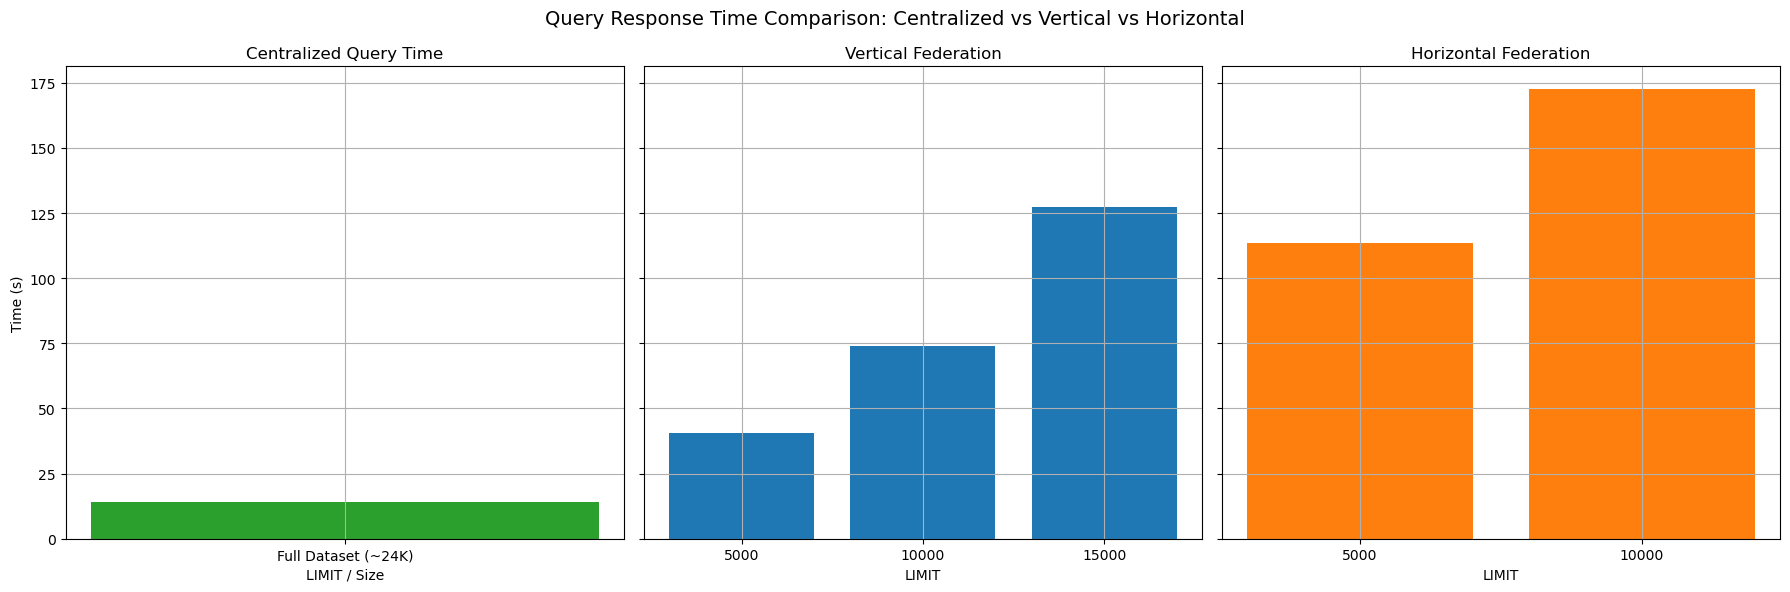

In [5]:
import matplotlib.pyplot as plt
import pandas as pd

# Simulated data
centralized_data = pd.DataFrame({
    'Model': ['Centralized'],
    'LIMIT': ['Full Dataset (~24K)'],
    'Time': [14.21],
    'Rows': [24448]
})

vertical_data = pd.DataFrame({
    'Model': ['Vertical'] * 3,
    'LIMIT': [5000, 10000, 15000],
    'Time': [40.58, 73.93, 127.3],
    'Rows': [5000, 10000, 15000]
})

horizontal_data = pd.DataFrame({
    'Model': ['Horizontal'] * 2,
    'LIMIT': [5000, 10000],
    'Time': [113.71, 172.70],
    'Rows': [5000, 10000]
})

# Combine for plotting
plot_data = pd.concat([centralized_data, vertical_data, horizontal_data], ignore_index=True)

# Create the plot
fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# Use professional-style color palette
colors = {
    'Centralized': '#2ca02c',  # green
    'Vertical': '#1f77b4',     # blue
    'Horizontal': '#ff7f0e'    # orange
}

# Centralized
axs[0].bar(centralized_data['LIMIT'], centralized_data['Time'], color=colors['Centralized'])
axs[0].set_title('Centralized Query Time')
axs[0].set_ylabel('Time (s)')
axs[0].set_xlabel('LIMIT / Size')
axs[0].grid(True)

# Vertical
axs[1].bar(vertical_data['LIMIT'].astype(str), vertical_data['Time'], color=colors['Vertical'])
axs[1].set_title('Vertical Federation')
axs[1].set_xlabel('LIMIT')
axs[1].grid(True)

# Horizontal
axs[2].bar(horizontal_data['LIMIT'].astype(str), horizontal_data['Time'], color=colors['Horizontal'])
axs[2].set_title('Horizontal Federation')
axs[2].set_xlabel('LIMIT')
axs[2].grid(True)

plt.suptitle('Query Response Time Comparison: Centralized vs Vertical vs Horizontal', fontsize=14)
plt.tight_layout()
plt.show()


Simple Query – Batch Results

Query time vs. LIMIT for vertical/horizontal

Rows returned by species per LIMIT

# Guidelines

Here are **clear, practical guidelines** recommended for each data access model (Direct, Centralized, and Decentralized), based on your deliverable’s evaluation and experimental findings:

---

### ✅ **Guidelines for Direct Data Sharing**

* **When to Use:**
  Use for small-scale, short-term, or early-stage projects where agility and minimal technical setup are priorities.

* **Best Practices:**

  * Limit to low-volume data exchanges.
  * Use clear bilateral data sharing agreements.
  * Always anonymize sensitive data before sharing.
  * Document metadata, even in simple spreadsheets, to improve traceability.
  * Using  surveillance dashboards and analytics.

---

### ✅ **Guidelines for Centralized Data Sharing**

* **When to Use:**
  Best for coordinated surveillance workflows where high performance, automation, and standardized data pipelines are required.

* **Best Practices:**

  * Require users to agree on a predefined data format.
  * Develop and maintain ingestion scripts (e.g., in R) for consistency.
  * Implement SHA-256 anonymization for privacy protection (with clear understanding that identifiers can't be reversed).
  * Ensure the central server has strong governance, uptime, and version control.
  * Support non-technical access via dashboards (e.g., Tableau) for wide usability.

---

### ✅ **Guidelines for Decentralized (Federated) Access using Solid Pods**

* **When to Use:**
  Ideal for distributed networks where data providers need full ownership and privacy, such as labs or farms unwilling to share raw data centrally.

* **Best Practices:**

  * Align on a shared ontology (e.g., Livestock Health Ontology) before implementation.
  * Provide lightweight training for users on SPARQL and RDF concepts, or develop user-friendly tools to abstract these.
  * Configure Solid Pods with clear access policies and metadata (e.g., `schema:Dataset`).
  * Use a federated SPARQL engine (e.g., Comunica) to enable real-time querying without moving the data.
  * Apply pagination and query optimization techniques to manage performance.

---




# Next Steps:


Future efforts should build on the training and tools already delivered in DECIDE—such as:

- **Species-specific ontologies** developed in D1.2  
- The **ECPLF 2024 workshop on semantic data access** ([Agenda PDF](https://www.ecplf2024.it/wp-content/uploads/2024/08/Workshop-Objectives-and-Agenda-Final.pdf))  
- [**Annotated Jupyter notebooks** for using ontologies and querying SPARQL](https://github.com/decide-project-eu/LivestockHealthOntology)  
- [**Step-by-step tutorial for the Cattle Barometer**](https://decide-project-eu.github.io/case-studies-website/tutorials/cattle-barometer.html)  

To further reduce technical barriers, the project should shift from training to **more user-friendly tooling**. For example:

- The **Rosanne Semantic Excel Add-in** (Wigham et al., 2015) enables data providers to structure input directly within Excel using ontologies.
- On the front end, natural language interfaces could allow users to ask questions in plain English and receive both **visual answers (charts, graphs)** and **text summaries**, removing the need to write SPARQL queries or understand ontology details.

These steps wcentralized and ill help make decentralized, FAIR-aligned data sharing more **sustainable, scalable, and accessible** to non-technical users.
